In [1]:
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from scipy.stats import pearsonr
import optuna
import shap

import csv
import pandas as pd
import numpy as np

import pydotplus
from six import StringIO
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable
plt.rcParams['figure.dpi'] = 360

In [2]:
rosettes = [3,6,7,11,12,13,14,15,18,19]

def graph_r(r):

    nodes = []
    edges = []
    edges_distances = []

    with open(f'../data/rosette{r}_nodes.csv', mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        for row in csv_reader:
            if (row!=0):
                values = list(row.values())
                n = []
                n.append(float(values[0]))
                n.append(float(values[1]))
                n.extend(22.5-2.5*np.log10([float(n) for n in values[2:-1]]))
                n.append(float(values[-1]))
                nodes.append(n)

    with open(f'../data/rosette{r}_edges.csv', mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        for row in csv_reader:
            if (row!=0):
                edges_distances.append([float(n) for n in list(row.values())])
                edges.append([float(n) for n in list(row.values())][:2])

    return (nodes,edges,edges_distances)

### Hyperparameter tuning

In [3]:
class ModelOptimizaton:

    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test

    def objective(self, trial):
        criterion = trial.suggest_categorical('criterion', ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'])
        n_estimators = trial.suggest_int('n_estimators', 5, 100)
        max_depth = trial.suggest_int('max_depth', 2, 10)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        regressor = RandomForestRegressor(criterion=criterion, n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, random_state=0)
        regressor.fit(self.x_train, self.y_train)
        return regressor.score(self.x_test, self.y_test)

if __name__=='__main__':
    nodes, _, _ = graph_r(rosettes[0])
    x = [[flux_g, flux_r, flux_z, flux_w1, flux_w2, z] for [_, _, flux_g, flux_r, flux_z, flux_w1, flux_w2, z] in nodes]
    y = [mass for [_, mass, _, _, _, _, _, _] in nodes]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.8, random_state=42)
    model = ModelOptimizaton(x_train, x_test, y_train, y_test)
    study = optuna.create_study(direction='maximize')
    study.optimize(model.objective, n_trials=100)

[I 2024-01-12 15:33:05,278] A new study created in memory with name: no-name-0c81e469-7c54-4a54-99e4-e18695f0fe11
[I 2024-01-12 15:33:15,882] Trial 0 finished with value: 0.8882249179992595 and parameters: {'criterion': 'absolute_error', 'n_estimators': 80, 'max_depth': 6, 'min_samples_split': 4}. Best is trial 0 with value: 0.8882249179992595.
[I 2024-01-12 15:33:27,027] Trial 1 finished with value: 0.9025509776208102 and parameters: {'criterion': 'absolute_error', 'n_estimators': 68, 'max_depth': 9, 'min_samples_split': 5}. Best is trial 1 with value: 0.9025509776208102.
[I 2024-01-12 15:33:27,985] Trial 2 finished with value: 0.7504556049806781 and parameters: {'criterion': 'poisson', 'n_estimators': 71, 'max_depth': 3, 'min_samples_split': 5}. Best is trial 1 with value: 0.9025509776208102.
[I 2024-01-12 15:33:29,353] Trial 3 finished with value: 0.8938481495343066 and parameters: {'criterion': 'absolute_error', 'n_estimators': 8, 'max_depth': 8, 'min_samples_split': 5}. Best is tr

In [4]:
study.best_params

{'criterion': 'friedman_mse',
 'n_estimators': 82,
 'max_depth': 10,
 'min_samples_split': 5}

In [5]:
study.best_value

0.9041276397817932

In [6]:
param = study.best_params
regressor = RandomForestRegressor(criterion=param['criterion'], n_estimators=param['n_estimators'], max_depth=param['max_depth'], min_samples_split=param['min_samples_split'], random_state=0)
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)

r2, mse, pc = r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), pearsonr(y_test, y_pred).statistic
print(f'R^2: {r2}')
print(f'mse: {mse}')
print(f'Pearson correlation: {pc}')

R^2: 0.9041276397817932
mse: 0.03563137540158694
Pearson correlation: 0.9509073360241717


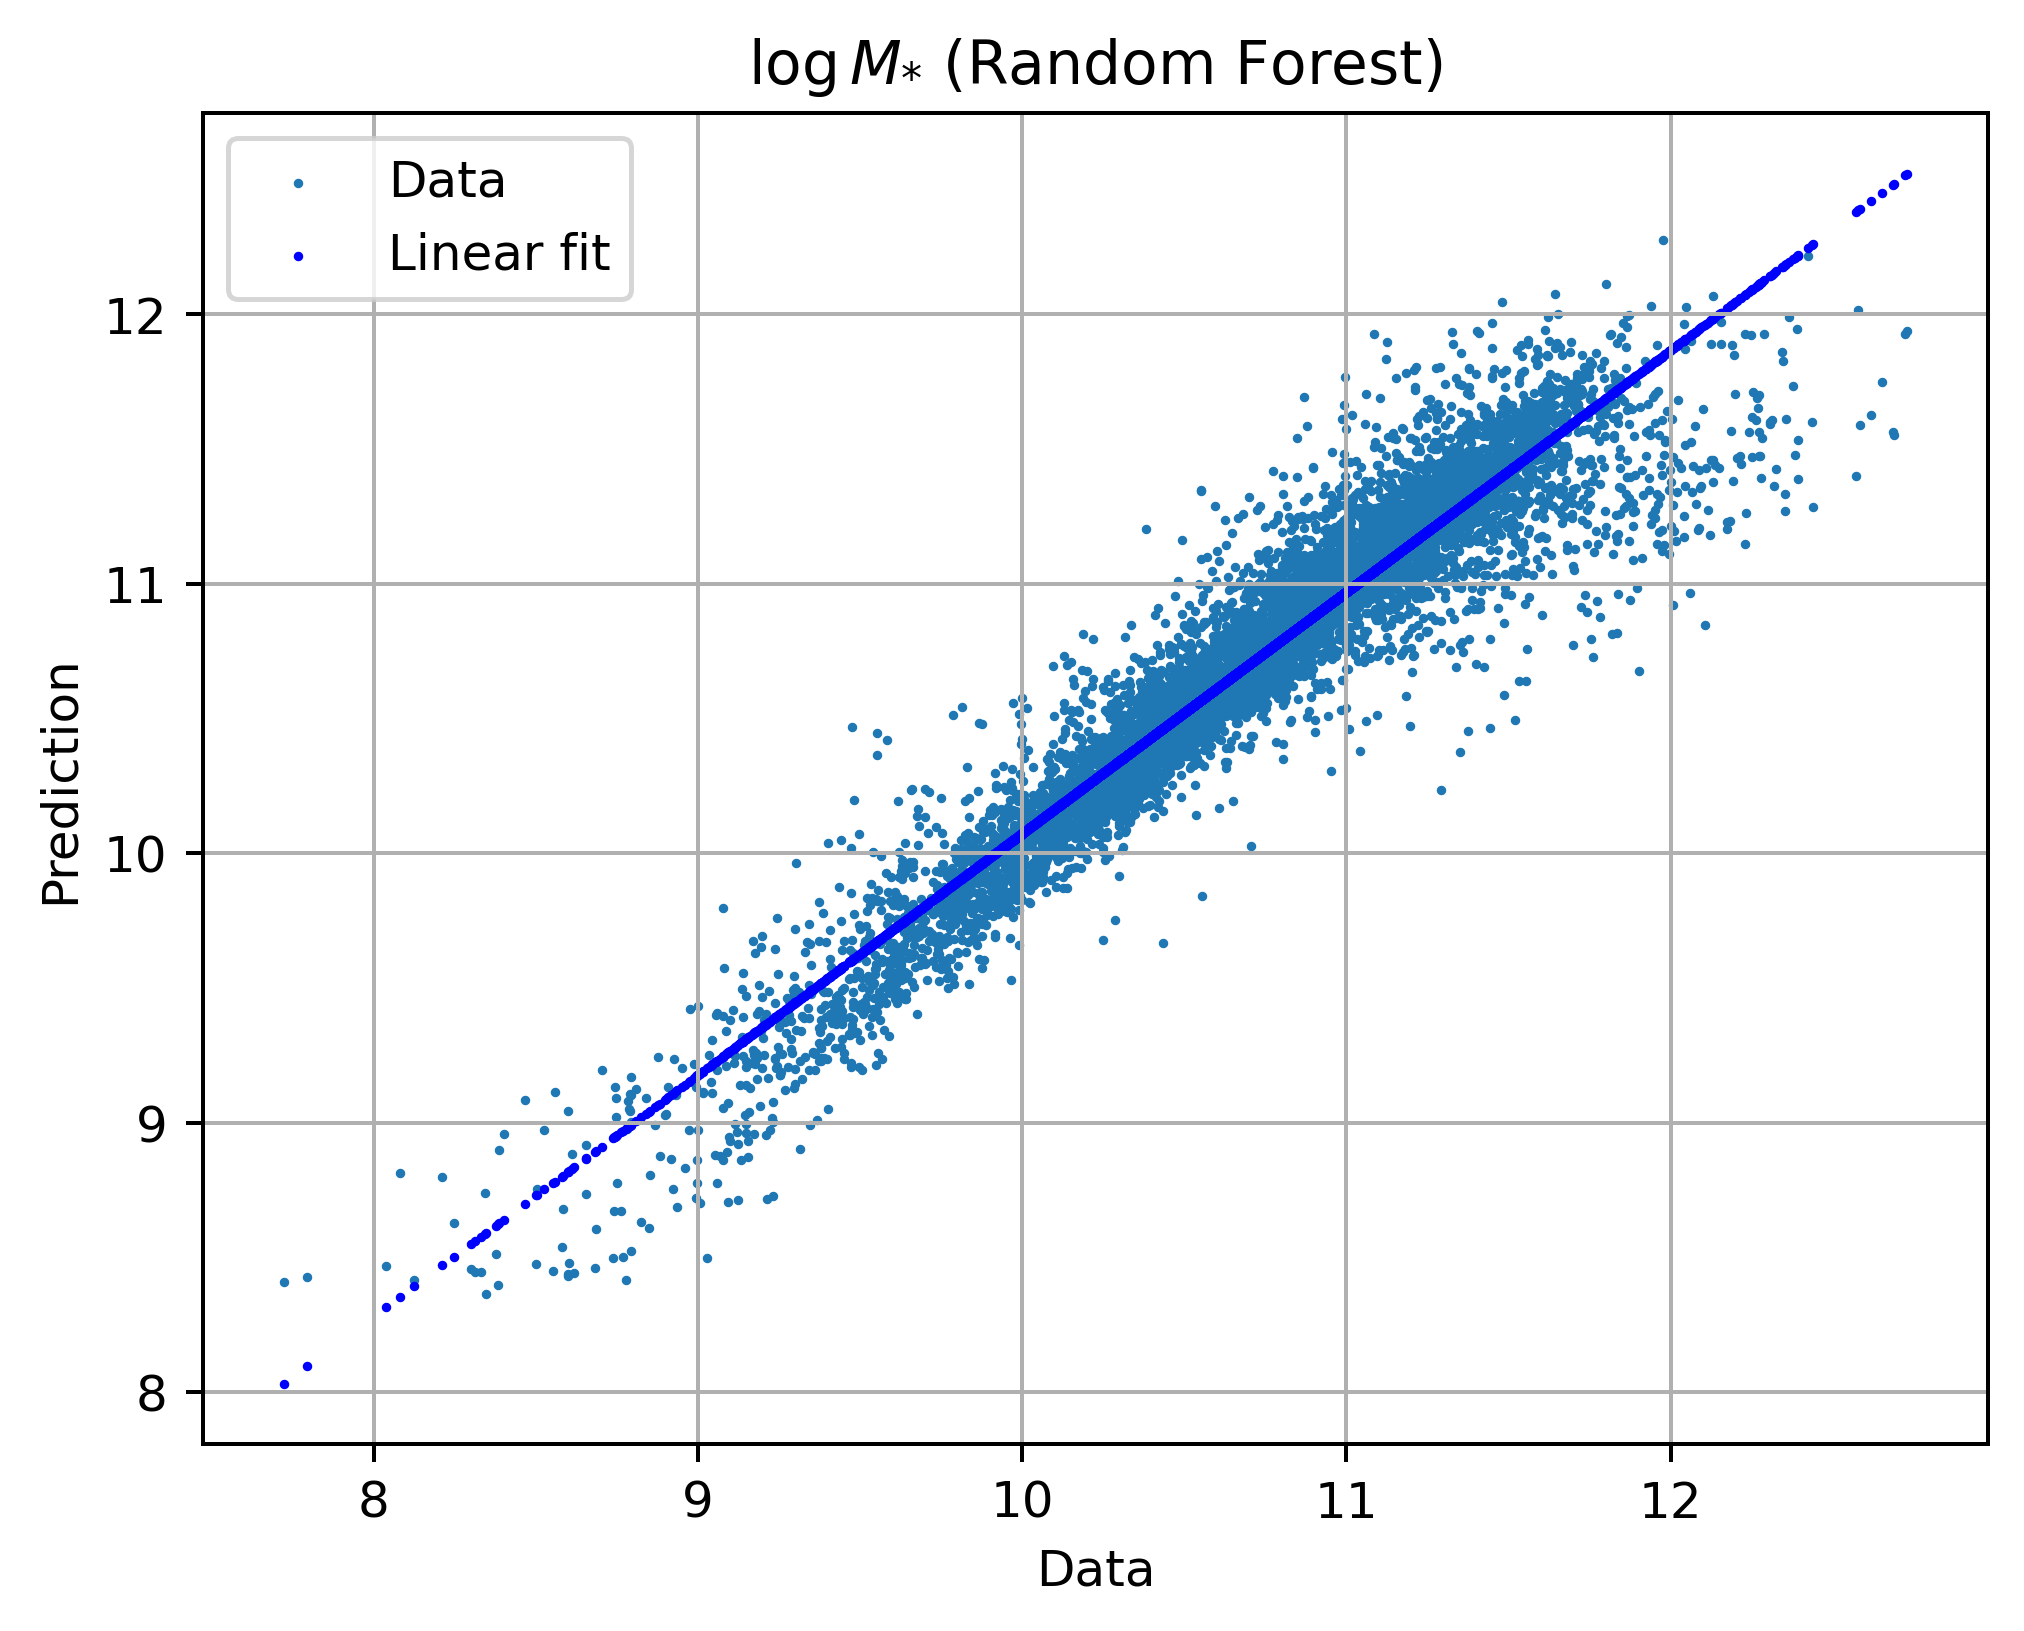

In [7]:
slope, intercept = np.polyfit(y_test, y_pred, 1)
r = slope*np.array(y_test)+intercept

fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, s=0.8)
ax.scatter(y_test, r, color='b', s=0.8)
ax.set_ylabel('Prediction')
ax.set_xlabel('Data')
plt.title(r'$\log M_{*}$ (Random Forest)')
plt.legend(['Data', 'Linear fit'])
plt.grid()
plt.show()

Graphviz tree

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.797619 to fit



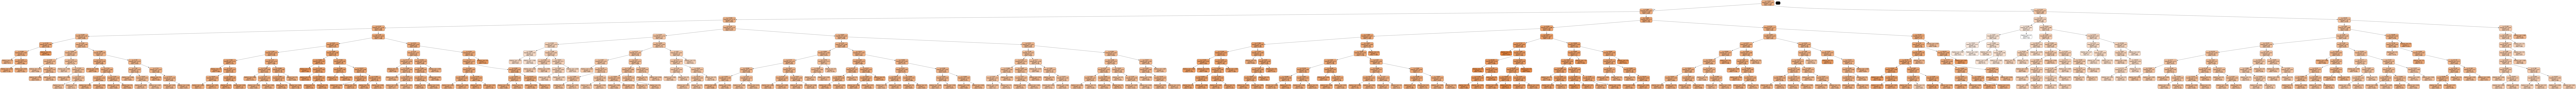

In [8]:
tree = regressor.estimators_[0]

dot_data = StringIO()
export_graphviz(tree, out_file=dot_data, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

Feature importances

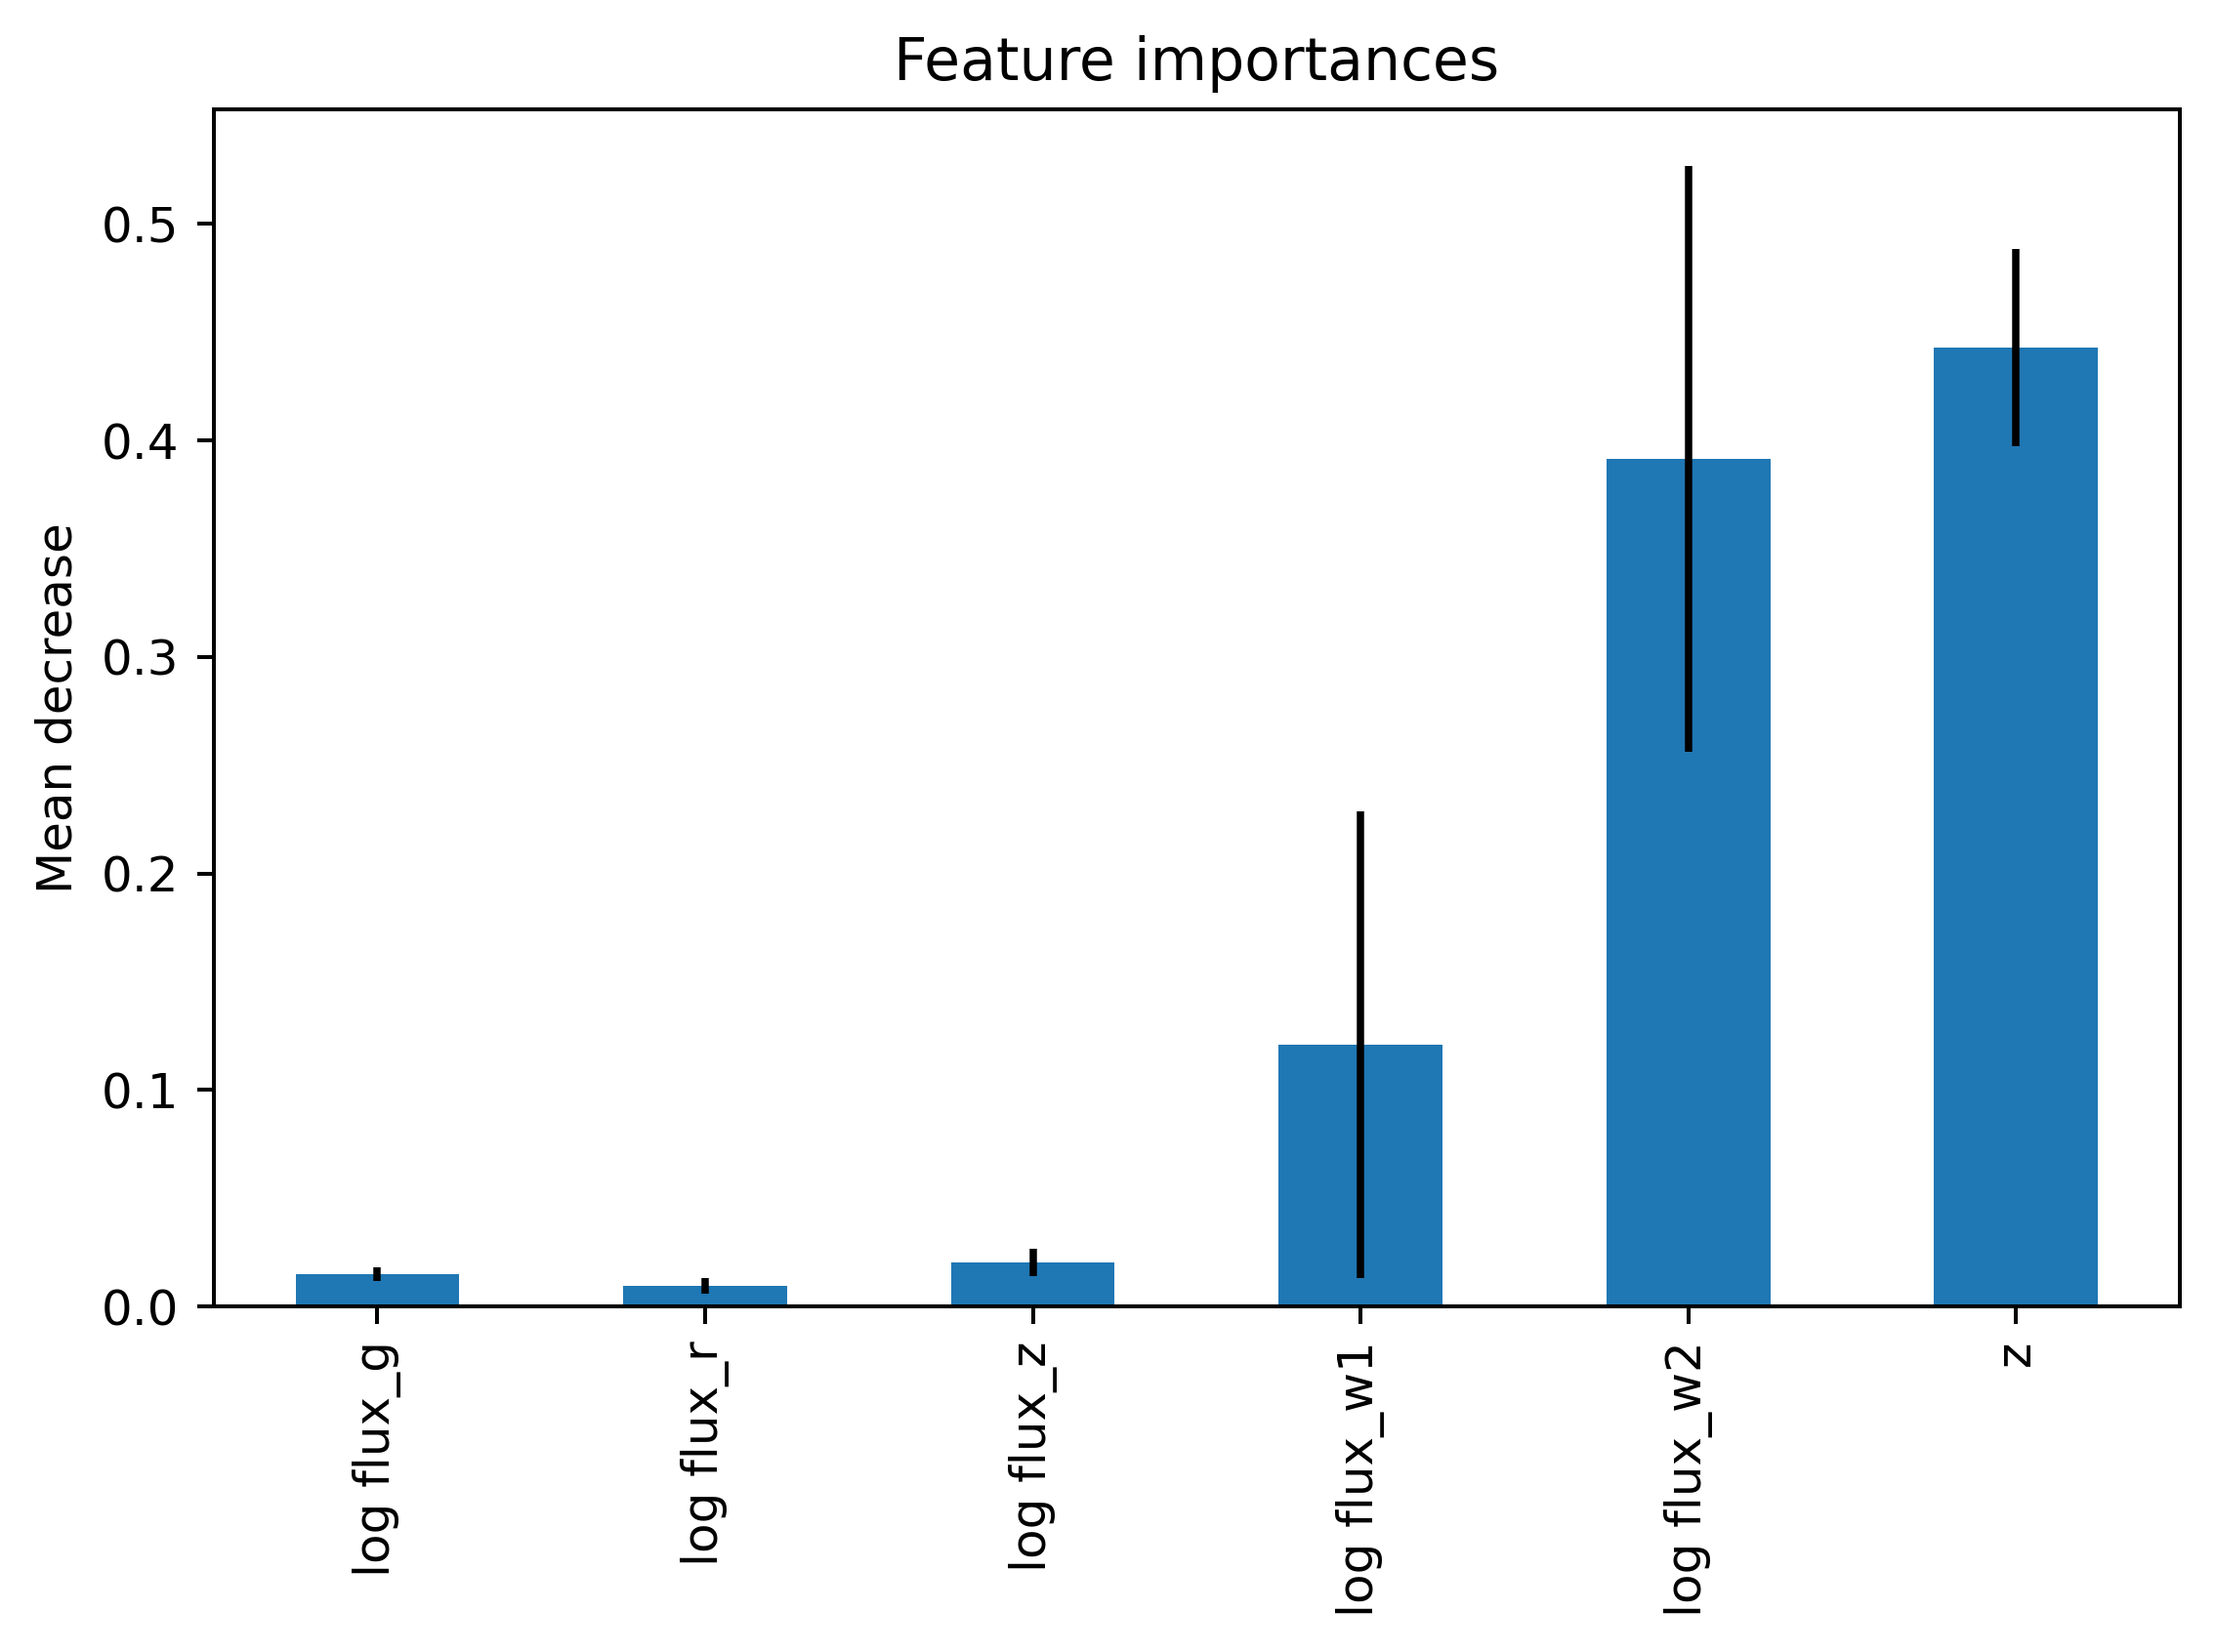

In [9]:
importances = regressor.feature_importances_
std = np.std([tree.feature_importances_ for tree in regressor.estimators_], axis=0)

props = ['log flux_g', 'log flux_r', 'log flux_z', 'log flux_w1', 'log flux_w2', 'z']
feature_names = [f"{i}" for i in props]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease")
fig.tight_layout()

Shap values

In [10]:
explainer = shap.Explainer(regressor, np.array(x_test))
shap_values = explainer(np.array(x_test))

100%|===================| 8892/8926 [02:25<00:00]        

In [11]:
shap_values

.values =
array([[ 0.01618661,  0.01574809,  0.06419758,  0.25448046,  0.28880369,
        -0.36714468],
       [ 0.00957884, -0.00965292, -0.0111928 ,  0.0400527 ,  0.15336245,
         0.51213209],
       [ 0.0191884 , -0.0020928 ,  0.0124489 , -0.01160051, -0.03077534,
        -0.31943535],
       ...,
       [-0.04292182,  0.01881279, -0.03171206, -0.08510272, -0.1118802 ,
         0.56600674],
       [ 0.0221663 , -0.00369486,  0.02336538,  0.06355695,  0.01826794,
        -0.10954607],
       [ 0.00867234,  0.00193669, -0.07801656, -0.29428421, -0.25886929,
        -0.05450539]])

.base_values =
array([10.74124864, 10.74124864, 10.74124864, ..., 10.74124864,
       10.74124864, 10.74124864])

.data =
array([[18.58714562, 17.54264417, 16.8469711 , 16.86600277, 17.21410056,
         0.16410207],
       [20.78971691, 19.22782325, 18.33713326, 17.92384303, 18.434905  ,
         0.37046631],
       [20.46383152, 19.34775338, 18.61339066, 18.67425449, 19.02385048,
         0.17013287],

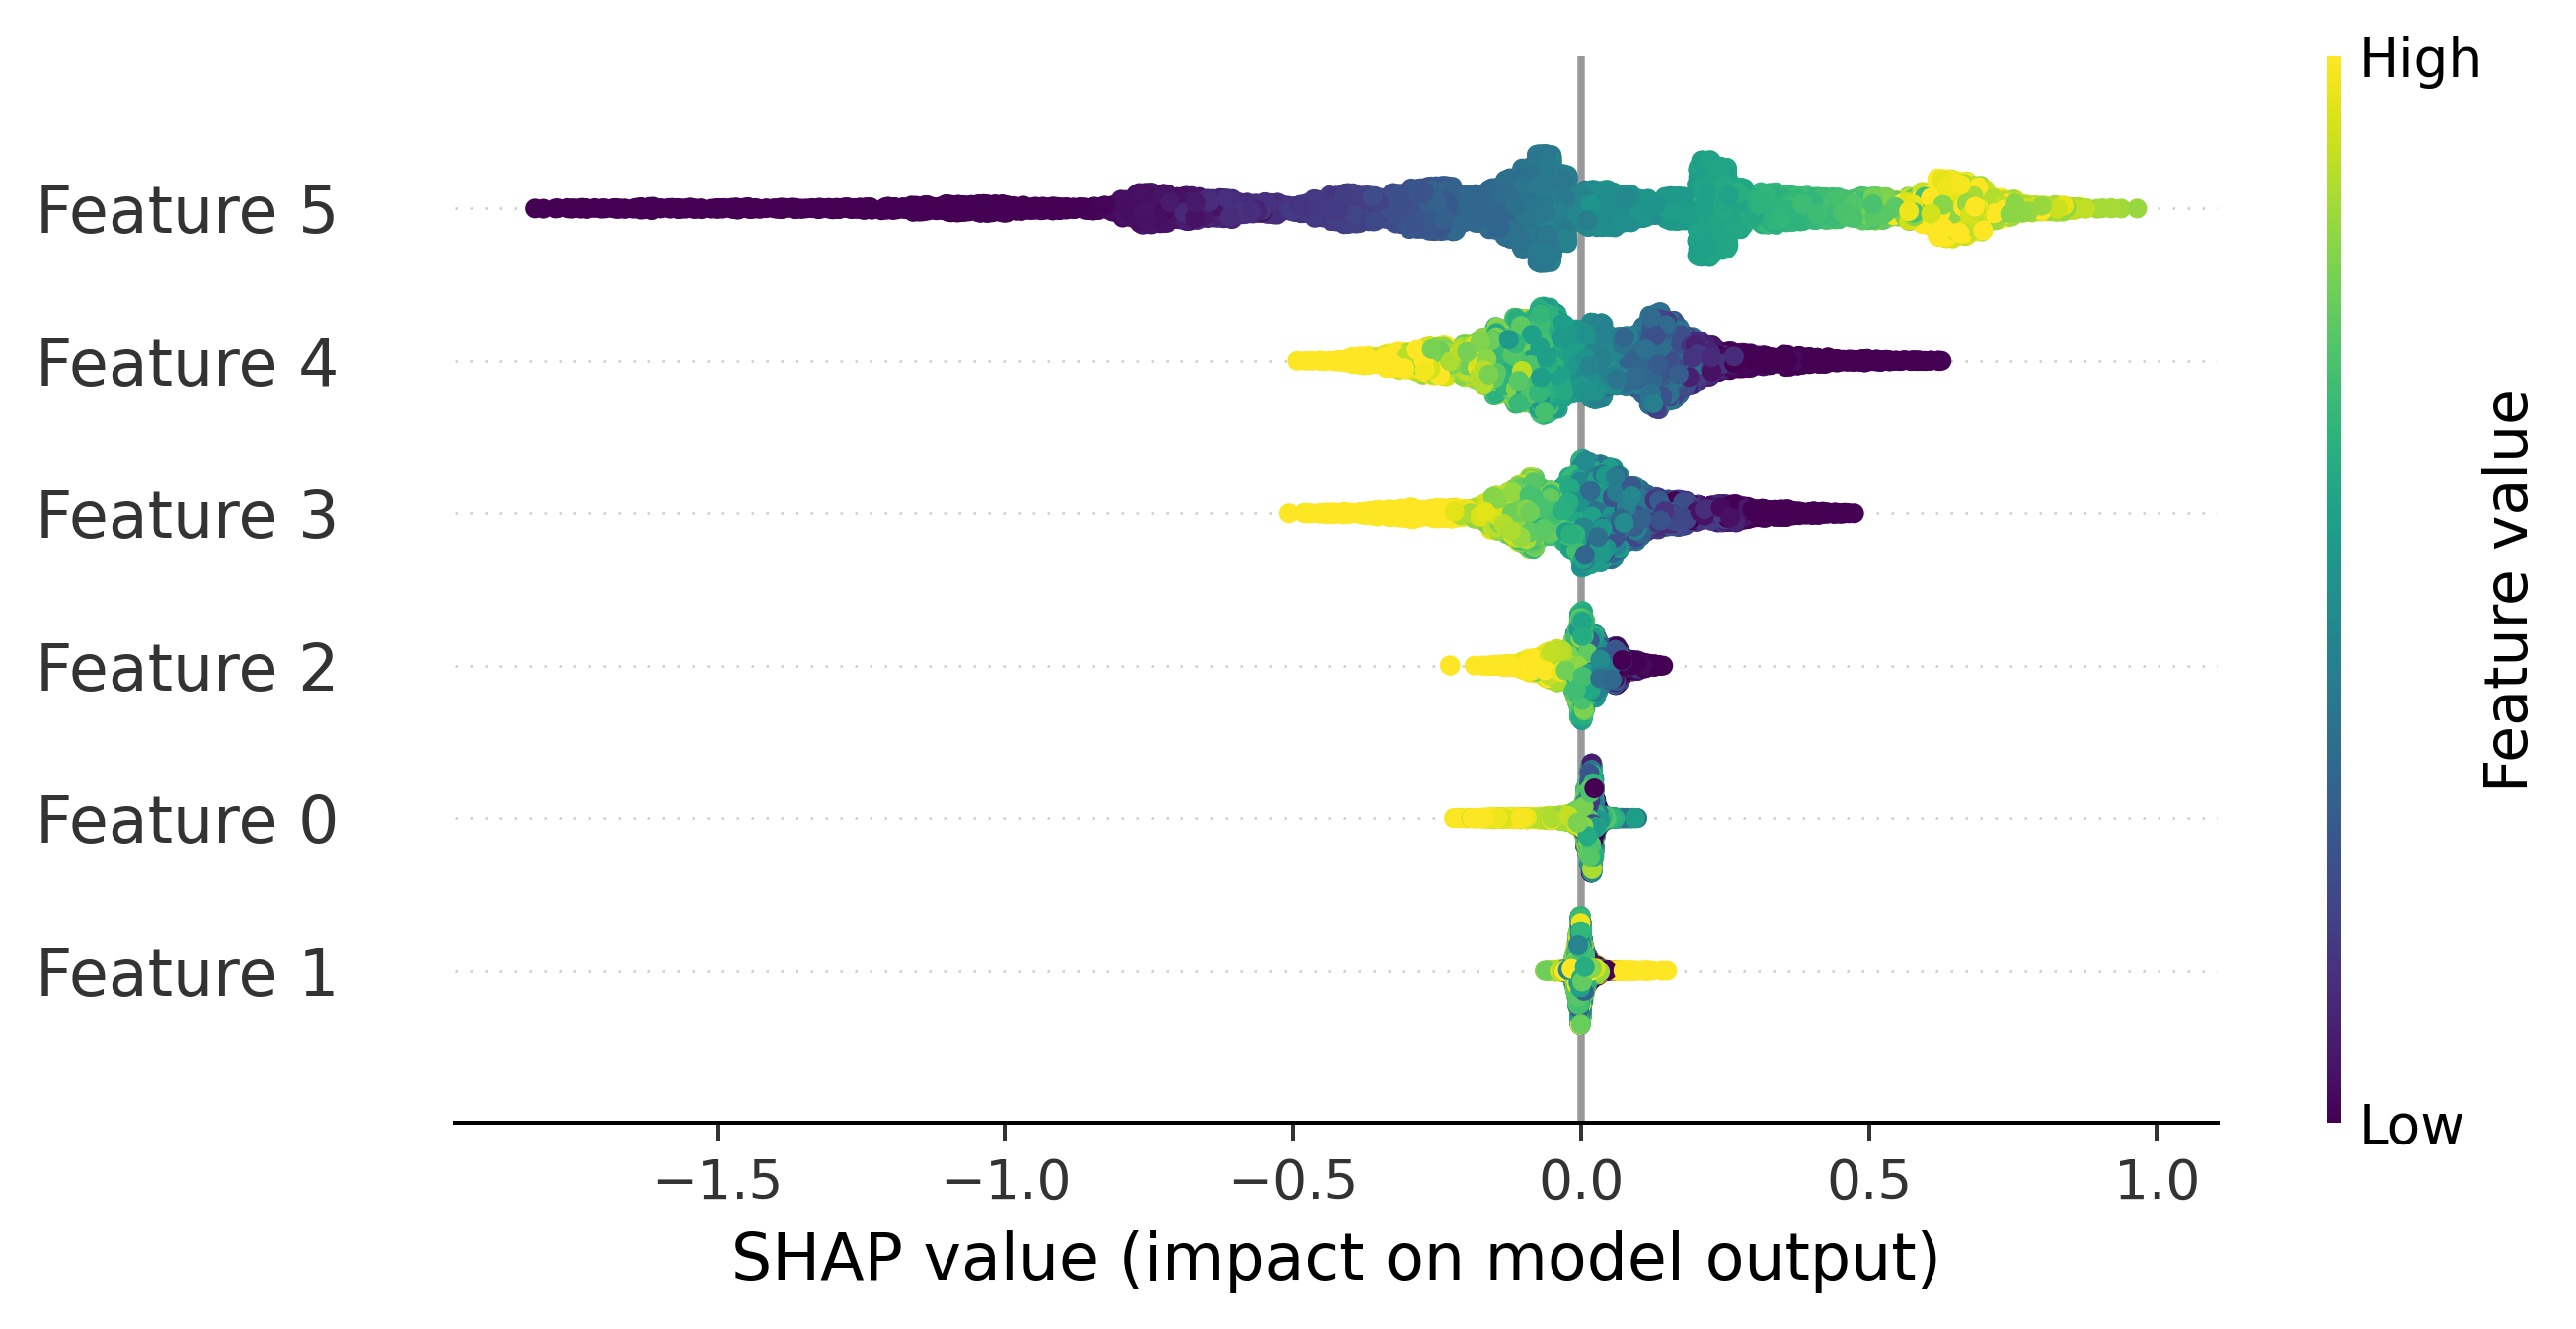

In [12]:
shap.plots.beeswarm(shap_values, color=cm.viridis)

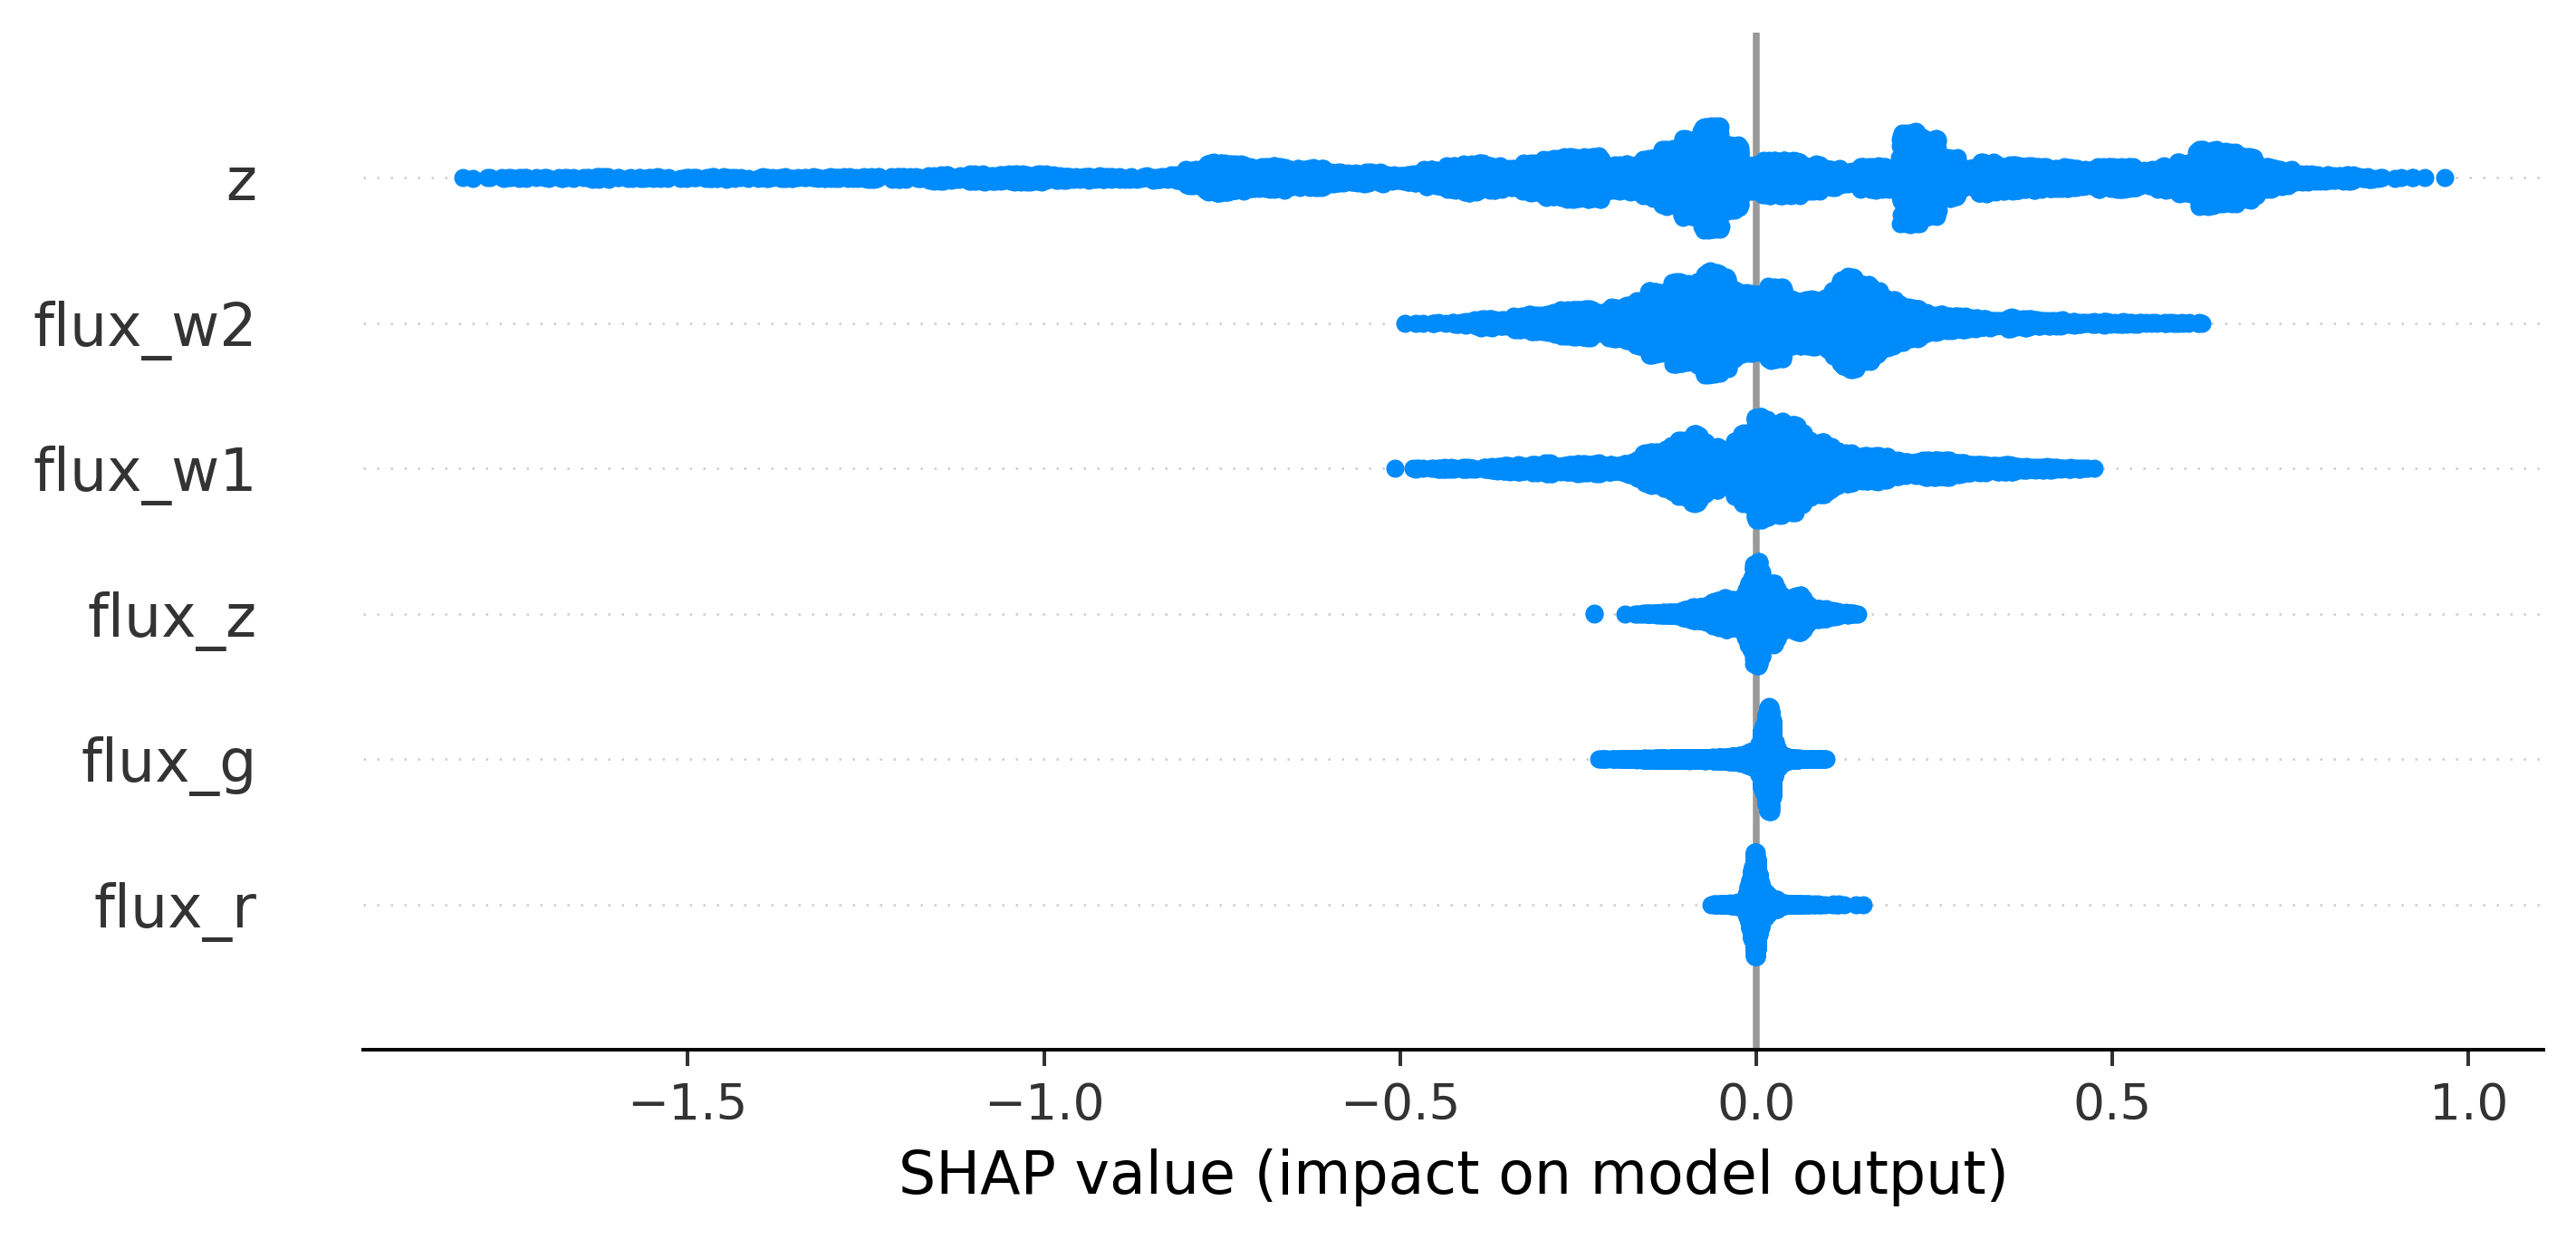

In [13]:
shap.summary_plot(shap_values, features=x_test, feature_names=['flux_g', 'flux_r', 'flux_z', 'flux_w1', 'flux_w2', 'z'], plot_type='dot', cmap='viridis')

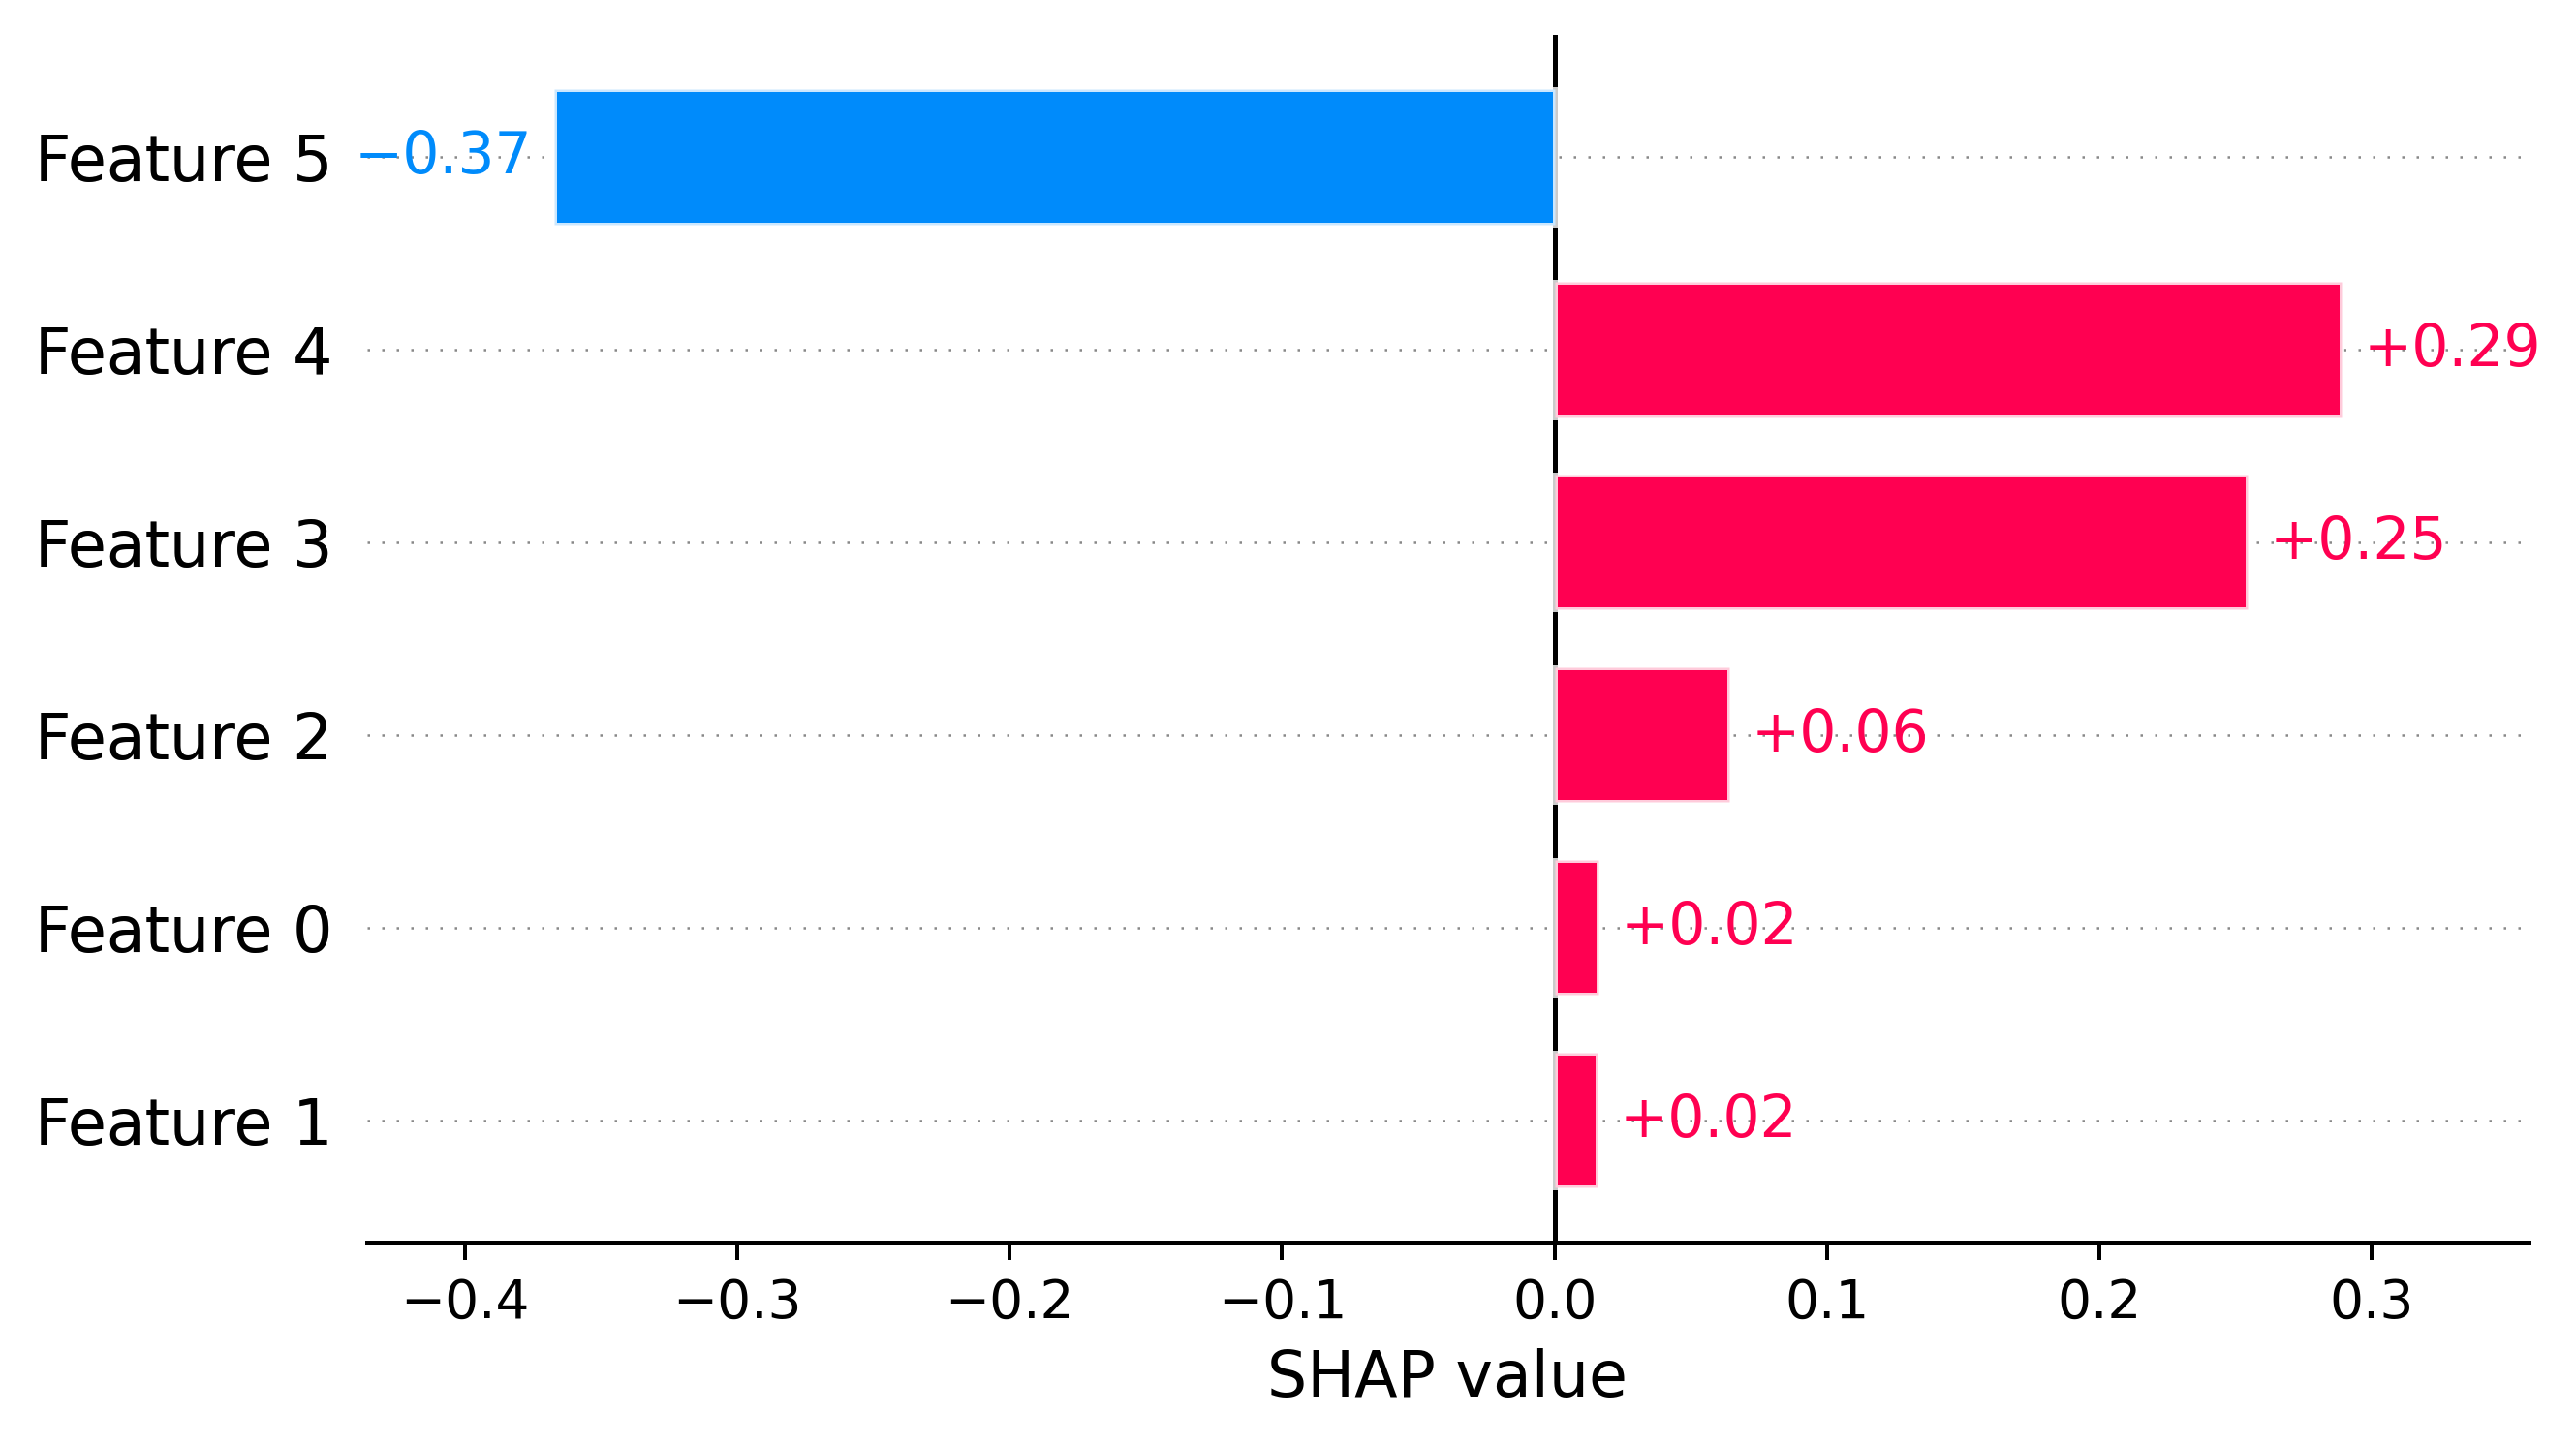

In [14]:
shap.plots.bar(shap_values[0])

In [15]:
shap_values = explainer.shap_values(np.array(x))

100%|===================| 11104/11157 [03:54<00:01]        

In [16]:
shap_values

array([[ 0.01621714, -0.0135333 , -0.00302289, -0.0252005 , -0.04635183,
         0.14211998],
       [ 0.00238343, -0.00698825,  0.00334001,  0.07447837,  0.01337951,
         0.09312673],
       [ 0.01835047, -0.00343025,  0.03119915,  0.01904503, -0.01521536,
        -0.2904078 ],
       ...,
       [ 0.01801871, -0.02423793, -0.00337493, -0.12216849, -0.06394178,
         0.05438977],
       [ 0.01781535,  0.00133099,  0.0298133 ,  0.09683863,  0.02478872,
        -0.00548464],
       [ 0.00825408, -0.02132768, -0.00395208,  0.06113051,  0.14783849,
         0.62795895]])

---

Adding a random column

In [17]:
regressor_rdm = RandomForestRegressor(criterion=param['criterion'], n_estimators=param['n_estimators'], max_depth=param['max_depth'], min_samples_split=param['min_samples_split'], random_state=0)

random_column = np.random.rand(len(y_train)) #random column
X_train_extended = np.column_stack((x_train, random_column))
regressor_rdm.fit(X_train_extended, y_train)

x_test_extended = np.column_stack((x_test, np.random.rand(len(y_test))))
y_pred_extended = regressor_rdm.predict(x_test_extended)

r2, mse, pc = r2_score(y_test, y_pred_extended), mean_squared_error(y_test, y_pred_extended), pearsonr(y_test, y_pred_extended).statistic
print(f'R^2: {r2}')
print(f'mse: {mse}')
print(f'Pearson correlation: {pc}')

R^2: 0.9032538726003717
mse: 0.03595611473609332
Pearson correlation: 0.9504458427761355


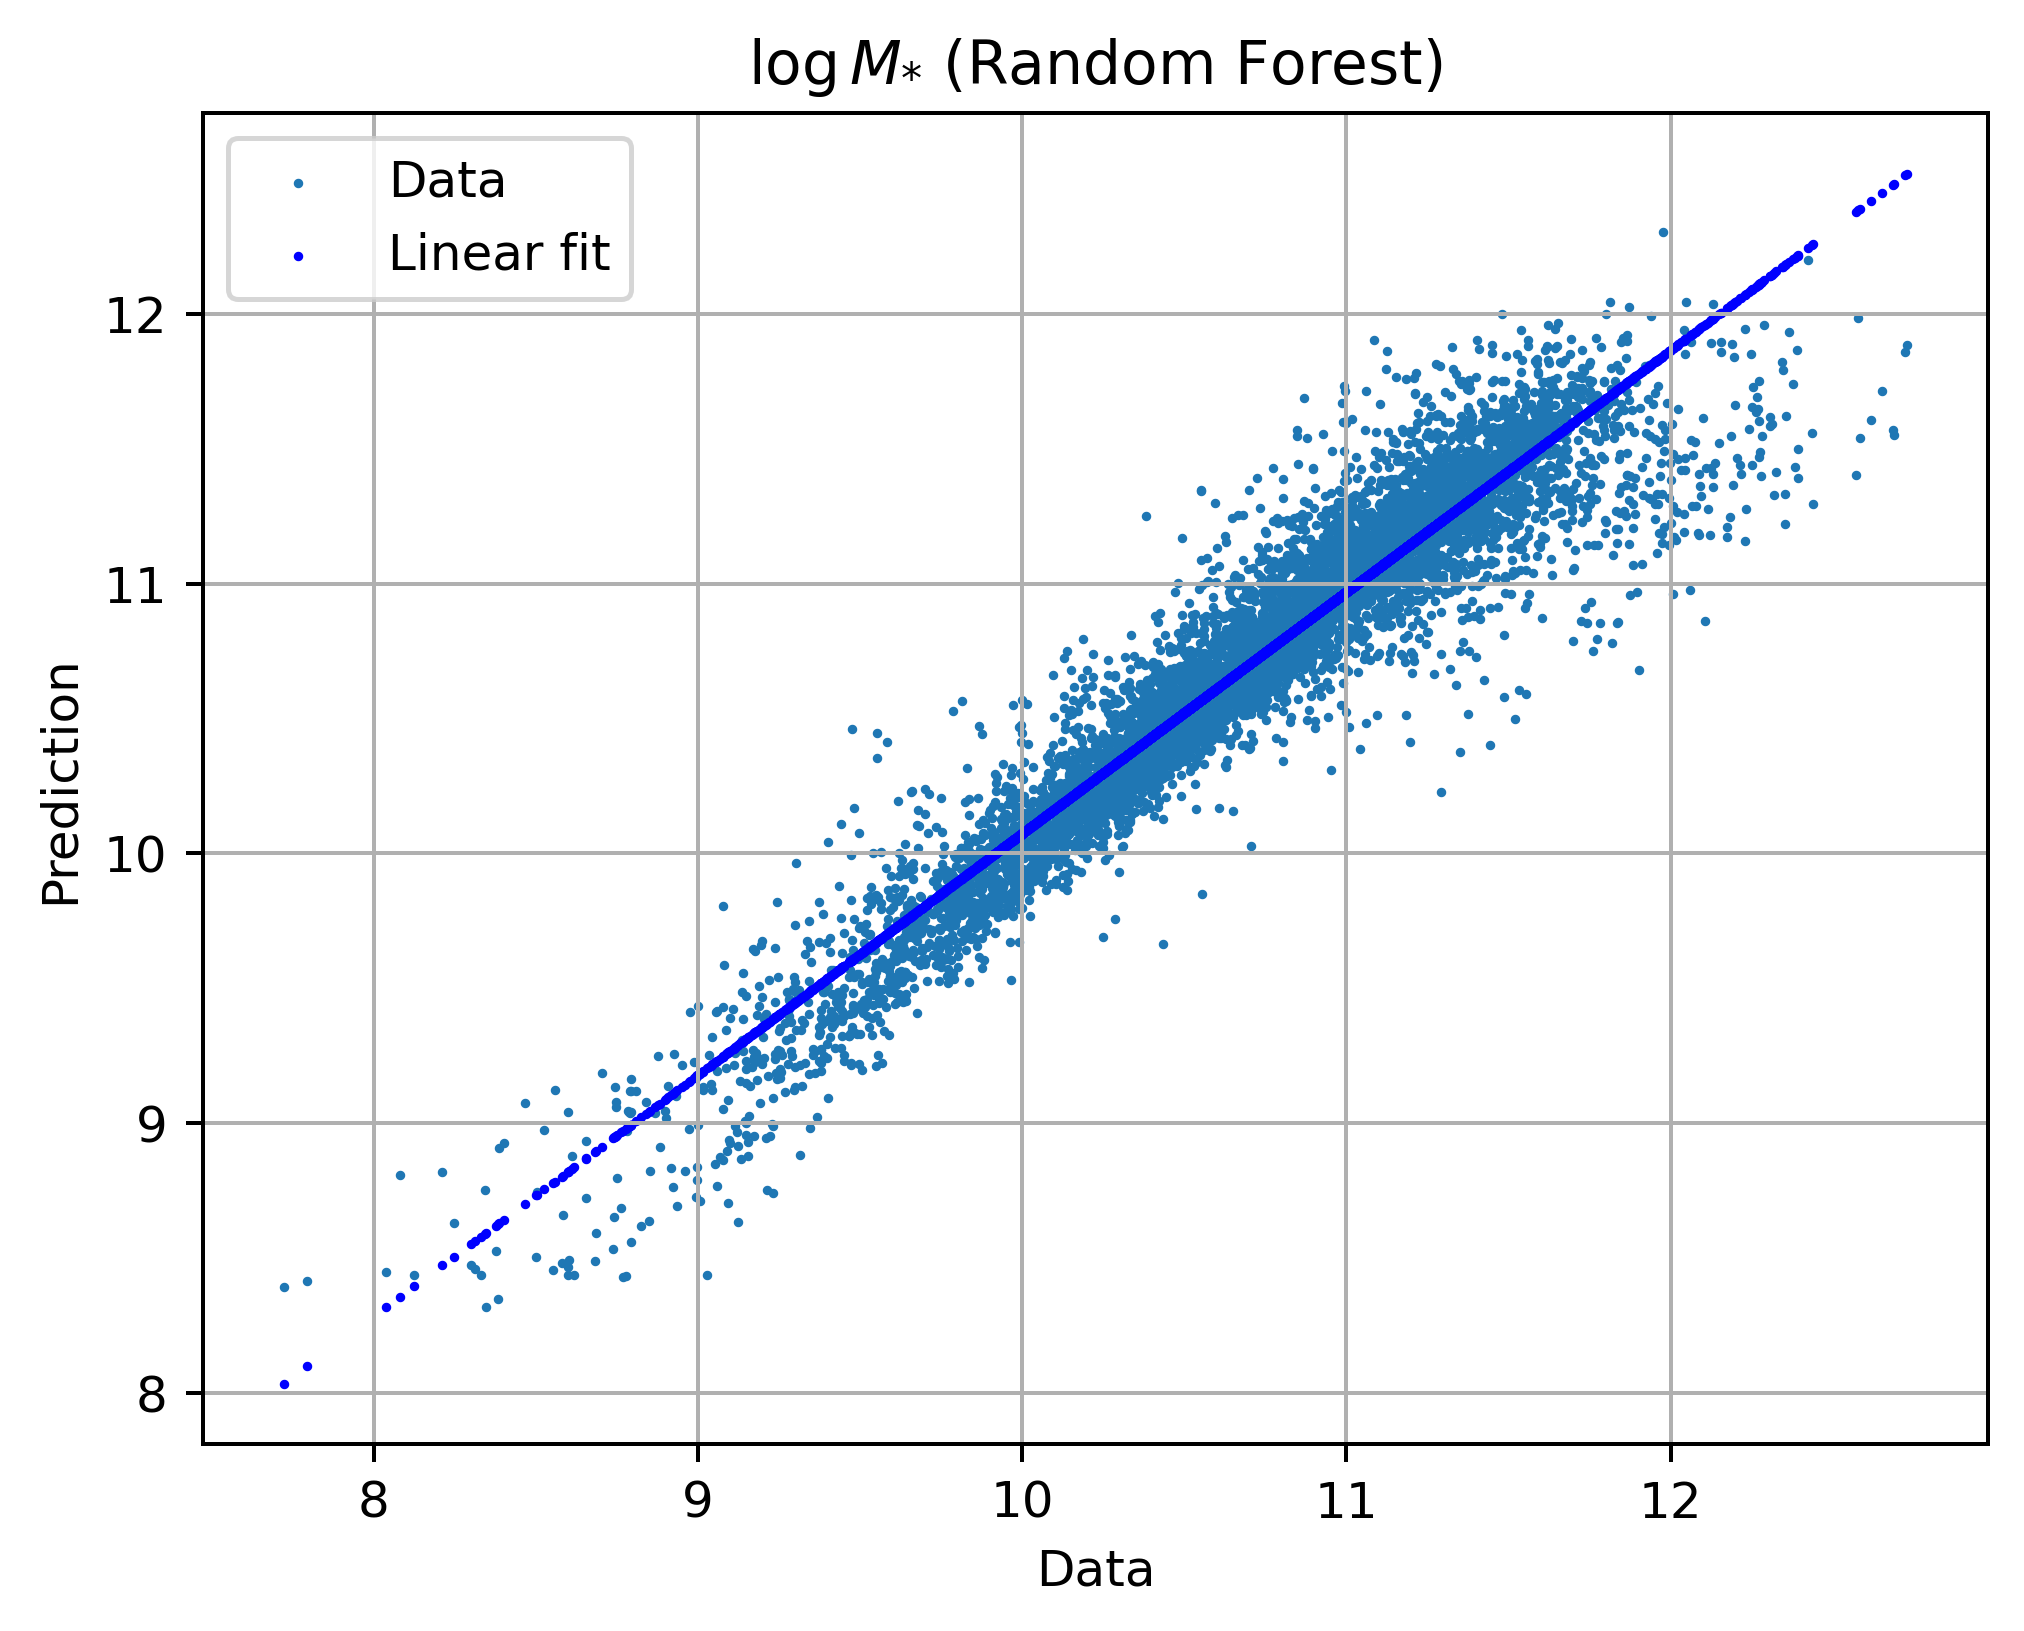

In [19]:
slope, intercept = np.polyfit(y_test, y_pred_extended, 1)
r = slope*np.array(y_test)+intercept

fig, ax = plt.subplots()
ax.scatter(y_test, y_pred_extended, s=0.8)
ax.scatter(y_test, r, color='b', s=0.8)
ax.set_ylabel('Prediction')
ax.set_xlabel('Data')
plt.title(r'$\log M_{*}$ (Random Forest)')
plt.legend(['Data', 'Linear fit'])
plt.grid()
plt.show()

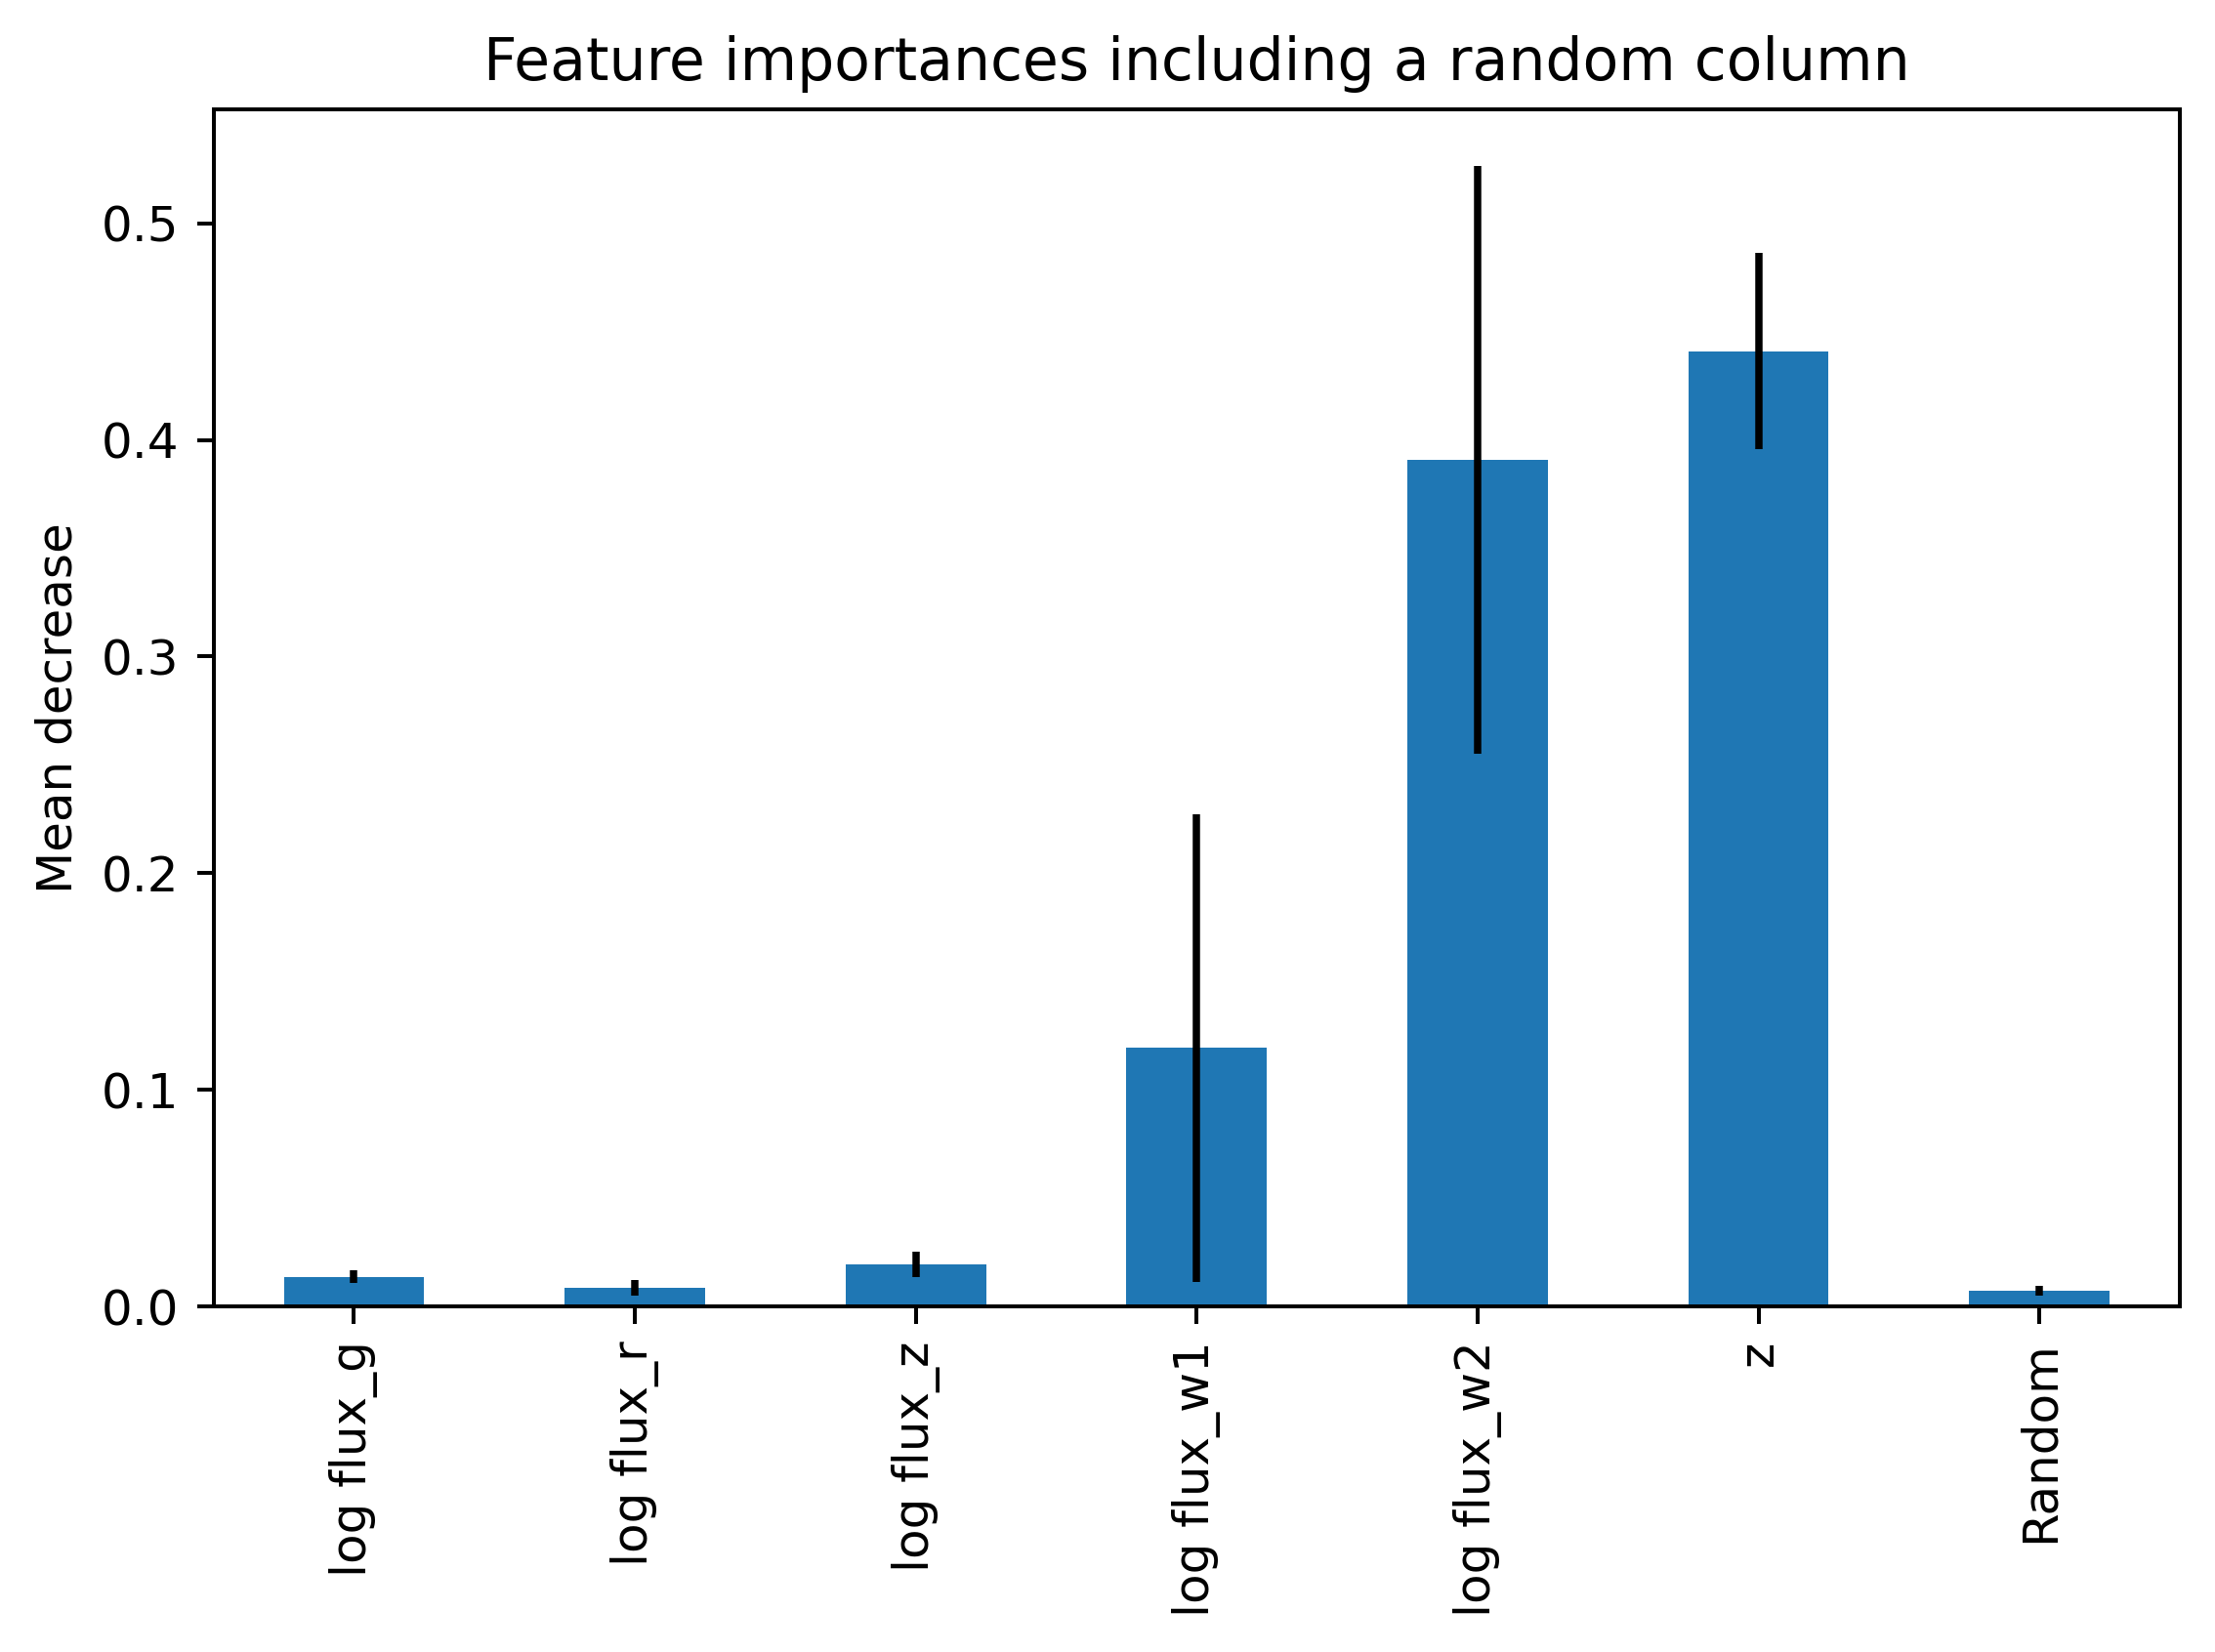

In [20]:
importances = regressor_rdm.feature_importances_
std = np.std([tree.feature_importances_ for tree in regressor_rdm.estimators_], axis=0)

props = ['log flux_g', 'log flux_r', 'log flux_z', 'log flux_w1', 'log flux_w2', 'z', 'Random']
feature_names = [f"{i}" for i in props[:-1]]
feature_names.append(props[-1])
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances including a random column")
ax.set_ylabel("Mean decrease")
fig.tight_layout()